# Golem project, Error404
## Temat 10: Klasyfikacja audio - rozpoznawanie komend

Wymagania:
- Wytrenowanie i przetestowanie 3 różnych sieci neuronowych. Dwie sieci wykonane samodzielnie, gdzie jedna korzysta z konwolucji 2D, a druga z 1D.
- Trzecia sieć ma korzystać z odmiennej architektury, niekoniecznie musi być własna, może być gotowy model.
- Zbadać wpływ parametrów na proces uczenia i uzyskane wyniki.
- Po wybraniu ostatecznych modeli, należy zbadać ich problemy i jak sobie radzą z rozpoznawaniem poszczególnych klas
Na plus:
- Wykorzystanie technik XAI (do najlepszego modelu lub wszystkich trzech).

Dane: https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/data
Zbiór testowy nie zawiera etykiet, dlatego należy zbiór testowy wydzielić ze zbioru treningowego

## Preprocessing of audio for 1D CNN

1. Resampling
2. VAD
3. Maybe padding with 0 to make signals be equal length
4. Log spectrogram (or MFCC, or PLP)
5. Features normalization with mean and std
6. Stacking of a given number of frames to get temporal information

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import scipy.signal as signal
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [ ]:
def calculate_global_mean_std(audio_dir="audio", target_freq=8000, n_mels=40, frame_length=0.025, frame_stride=0.01):
    """
    Function to calculate global mean and std from all audio samples in the dataset.
    This should be called before processing individual samples.
    """
    all_specs = []
    for label in os.listdir(audio_dir):
        if label == "_background_noise_":
            continue

        folder_path = os.path.join(audio_dir, label)
        for filename in os.listdir(folder_path):
            if filename.endswith(".wav"):
                filepath = os.path.join(folder_path, filename)
                audio, sr = librosa.load(filepath, sr=target_freq)

                energy = librosa.feature.rms(y=audio)
                vad_mask = energy.flatten() > np.percentile(energy, 10)
                vad_mask = np.tile(vad_mask, int(np.ceil(len(audio) / len(vad_mask))))[:len(audio)]
                audio = audio[vad_mask]

                max_length = target_freq
                if len(audio) > max_length:
                    audio = audio[:max_length]
                else:
                    audio = np.pad(audio, (0, max_length - len(audio)))

                hop_length = int(frame_stride * target_freq)
                n_fft = int(frame_length * target_freq)
                mel_spec = librosa.feature.melspectrogram(y=audio, sr=target_freq, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
                log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

                all_specs.append(log_mel_spec)

    all_specs = np.array(all_specs)
    global_mean = np.mean(all_specs)
    global_std = np.std(all_specs)

    return global_mean, global_std


global_mean, global_std = calculate_global_mean_std()
print(f"global mean: {global_mean}")
print(f"global std: {global_std}")

global mean: -51.92462921142578
global std: 21.454496383666992


In [ ]:
global_mean = -51.92462921142578
global_std = 21.454496383666992

def preprocess_audio(filepath, target_freq=8000, n_mels=40, frame_length=0.025, frame_stride=0.01):
    """
    Parameters:
        filepath (str): Path to the .wav file.
        target_freq (int): Target sampling rate (default: 8000 Hz).
        n_mels (int): Number of mel filter banks (default: 40).
        frame_length (float): Window size for STFT in seconds (default: 25ms).
        frame_stride (float): Step size for STFT in seconds (default: 10ms).

    Returns:
        np.ndarray: flattened 1D feature vector.
    """
    # 1. Resample to target sample rate.
    audio, sr = librosa.load(filepath, sr=target_freq)

    # 2. Apply Voice Activity Detection to remove silence
    energy = librosa.feature.rms(y=audio)
    vad_mask = energy.flatten() > np.percentile(energy, 10)
    vad_mask = np.tile(vad_mask, int(np.ceil(len(audio) / len(vad_mask))))[:len(audio)]
    audio = audio[vad_mask]

    # 3. Padding to fixed length (1 second = 8000 samples)
    max_length = target_freq
    if len(audio) > max_length:
        audio = audio[:max_length]
    else:
        audio = np.pad(audio, (0, max_length - len(audio)))

    # 4. Compute log mel spectrogram
    hop_length = int(frame_stride * target_freq)
    n_fft = int(frame_length * target_freq)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=target_freq, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # 5. Normalize and flatten
    log_mel_spec = np.nan_to_num(log_mel_spec)
    log_mel_spec = (log_mel_spec - global_mean) / global_std

    return log_mel_spec.flatten()

In [ ]:
feature_vector = preprocess_audio("audio/cat/0ab3b47d_nohash_0.wav")
print(feature_vector[:10])

[-0.8811939  -0.6636339  -0.8046606  -0.7404136  -0.84783    -0.8105409
 -0.69479436 -0.3679926  -0.9018657  -0.8808902 ]


In [ ]:
def load_excluded_files(test_file="testing_list.txt", val_file="validation_list.txt"):
    excluded_files = set()
    for file in [test_file, val_file]:
        if os.path.exists(file):
            with open(file, "r") as f:
                for line in f:
                    # store full path like 'bed/xyz.wav'
                    excluded_files.add(line.strip())

    return excluded_files

def create_dataset(audio_dir="audio"):
    """Processes all audio files and creates training dataset."""
    X = []  # feature vectors
    y = []  # labels
    labels = [folder for folder in os.listdir("audio") if folder != "_background_noise_"]
    label_map = {label: idx for idx, label in enumerate(labels)}
    excluded_files = load_excluded_files()

    for label in labels:

        label_dir = os.path.join(audio_dir, label)

        if not os.path.isdir(label_dir):
            continue

        for filename in os.listdir(label_dir):
            if filename.endswith(".wav"):
                # skip files in test and validation list
                relative_path = f"{label}/{filename}"
                if relative_path in excluded_files:
                    continue

                filepath = os.path.join(label_dir, filename)
                feature_vector = preprocess_audio(filepath)
                X.append(feature_vector)
                y.append(label_map[label])

    X = np.array(X)
    y = np.array(y)

    return X, y, label_map

In [ ]:
X, y, label_map = create_dataset()
np.savez("training_data.npz", X=X, y=y, label_map=label_map)
print(f"Dataset saved! X shape: {X.shape}, y shape: {y.shape}")
print(f"Label mapping: {label_map}")

Dataset saved! X shape: (51088, 4040), y shape: (51088,)
Label mapping: {'two': 0, 'left': 1, 'cat': 2, 'wow': 3, 'down': 4, 'marvin': 5, 'seven': 6, 'bird': 7, 'dog': 8, 'bed': 9, 'no': 10, 'three': 11, 'four': 12, 'up': 13, 'yes': 14, 'five': 15, 'tree': 16, 'nine': 17, 'go': 18, 'happy': 19, 'right': 20, 'sheila': 21, 'six': 22, 'stop': 23, 'zero': 24, 'house': 25, 'one': 26, 'off': 27, 'eight': 28, 'on': 29}


In [ ]:
def create_dataset_from_text(txt_file, label_map, audio_dir="audio"):
    """Processes audio files from txt and creates the dataset."""
    X = []  # feature vectors
    y = []  # labels

    # load filenames from txt file (they are WITHOUT 'audio/' prefix)
    with open(txt_file, "r") as f:
        included_files = set(line.strip() for line in f)

    labels = [folder for folder in os.listdir(audio_dir) if folder != "_background_noise_"]

    for label in labels:
        label_dir = os.path.join(audio_dir, label)

        if not os.path.isdir(label_dir):
            continue

        for filename in os.listdir(label_dir):
            if filename.endswith(".wav"):
                relative_path = f"{label}/{filename}"
                if relative_path not in included_files:
                    continue

                filepath = os.path.join(label_dir, filename)
                feature_vector = preprocess_audio(filepath)
                X.append(feature_vector)
                y.append(label_map[label])

    return np.array(X), np.array(y)

In [ ]:
data = np.load("training_data.npz", allow_pickle=True)
label_map = data["label_map"].item()

test_X, test_y = create_dataset_from_text(txt_file="testing_list.txt", label_map=label_map)
np.savez("testing_data.npz", X=test_X, y=test_y)
print(f"Testing dataset saved!")

Testing dataset saved!


In [ ]:
data = np.load("training_data.npz", allow_pickle=True)
label_map = data["label_map"].item()

val_X, val_y = create_dataset_from_text(txt_file="validation_list.txt", label_map=label_map)
np.savez("validation_data.npz", X=val_X, y=val_y)
print(f"Validation dataset saved!")

Validation dataset saved!


## 1D CNN implementation

- Use data augmentation and dropout to prevent overfitting.
- Optimizer: SGD or ADAM.
- Loss function: Categorical CrossEntropy.
- Activation function: ReLU in hidden layers.
- Add Batch Normalization for stable training.
- Use MaxPooling1D for downsampling.
- Final layers: Dense → Softmax for classification.
- Track accuracy and F1-score (better for imbalanced datasets).
- Implement Early Stopping to prevent overfitting.

In [9]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
torch.__version__

'2.5.1+cu124'

In [ ]:
np.__version__

'1.26.4'

In [ ]:
import scipy
scipy.__version__

'1.13.1'

In [ ]:
import sklearn
sklearn.__version__

'1.6.1'

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpeechCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SpeechCNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        # Global Average Pooling to reduce dimensionality
        self.gap = nn.AdaptiveAvgPool1d(1)

        self.dropout = nn.Dropout(0.4)

        # Fully connected layers
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.01)
        x = self.pool1(x)

        x = F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.01)
        x = self.pool2(x)

        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.01)
        x = self.pool3(x)

        # Global Average Pooling
        x = self.gap(x)
        x = torch.flatten(x, start_dim=1)

        x = self.dropout(F.leaky_relu(self.fc1(x), negative_slope=0.01))
        x = self.dropout(F.leaky_relu(self.fc2(x), negative_slope=0.01))
        x = self.fc3(x)  # output layer

        return x


In [11]:
class SpeechDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = self.X[idx]
        label = self.y[idx]
        sample = sample.unsqueeze(0)  # works, don't touch
        return sample, label


In [ ]:
def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

            # collects predictions and labels for F1 calculation
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return total_loss / len(loader), accuracy, f1

In [12]:
def train_model(model, train_loader, val_loader, num_epochs=20, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float("inf")
    patience = 5  # early stopping threshold
    wait = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        all_preds, all_labels = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

            # collect predictions and labels for F1 calculation
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_acc = correct / total
        train_f1 = f1_score(all_labels, all_preds, average='weighted')

        # evaluate on validation set
        val_loss, val_acc, val_f1 = evaluate_model(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {total_loss/len(train_loader):.4f} - "
              f"Train Acc: {train_acc:.4f} - Train F1: {train_f1:.4f} - "
              f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f} - Val F1: {val_f1:.4f}")

        # early stop
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break

In [ ]:
import gdown

file_id = "1f_pnucS-NK77DHKXAbkumQKtvAu44F9i"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
gdown.download(url, "train_data.npz", quiet=False)

train_data = np.load("train_data.npz", allow_pickle=True)
X_train, y_train = train_data["X"], train_data["y"]

val_file_id = "1HiKUWaqtlLA26XdrE2nHQ-PevEbp-Opz"
val_url = f"https://drive.google.com/uc?export=download&id={val_file_id}"
gdown.download(val_url, "validation_data.npz", quiet=False)

val_data = np.load("validation_data.npz", allow_pickle=True)
X_val, y_val = val_data["X"], val_data["y"]

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1f_pnucS-NK77DHKXAbkumQKtvAu44F9i
From (redirected): https://drive.google.com/uc?export=download&id=1f_pnucS-NK77DHKXAbkumQKtvAu44F9i&confirm=t&uuid=871c5994-2862-4d68-a062-614b7fb825fa
To: /content/train_data.npz
100%|██████████| 826M/826M [00:09<00:00, 83.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=1HiKUWaqtlLA26XdrE2nHQ-PevEbp-Opz
From (redirected): https://drive.google.com/uc?export=download&id=1HiKUWaqtlLA26XdrE2nHQ-PevEbp-Opz&confirm=t&uuid=8dbf56ba-9aff-4d3d-9ede-0e8af79948bc
To: /content/validation_data.npz
100%|██████████| 110M/110M [00:01<00:00, 65.9MB/s]


In [ ]:
print("Min label:", np.min(y_train))
print("Max label:", np.max(y_train))
print("Unique labels:", np.unique(y_train))

Min label: 0
Max label: 29
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


In [ ]:
batch_size = 16
train_dataset = SpeechDataset(X_train, y_train)
val_dataset = SpeechDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

input_size = X_train.shape[1]
num_classes = len(np.unique(y_train))
model = SpeechCNN(input_size, num_classes)

train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001)

Epoch 1/10 - Train Loss: 2.7297 - Train Acc: 0.1845 - Train F1: 0.1655 - Val Loss: 2.2920 - Val Acc: 0.2817 - Val F1: 0.2320
Epoch 2/10 - Train Loss: 2.2167 - Train Acc: 0.3138 - Train F1: 0.3005 - Val Loss: 2.0199 - Val Acc: 0.3635 - Val F1: 0.3443
Epoch 3/10 - Train Loss: 1.9961 - Train Acc: 0.3817 - Train F1: 0.3718 - Val Loss: 2.0214 - Val Acc: 0.3767 - Val F1: 0.3640
Epoch 4/10 - Train Loss: 1.8400 - Train Acc: 0.4346 - Train F1: 0.4264 - Val Loss: 2.1038 - Val Acc: 0.3670 - Val F1: 0.3362
Epoch 5/10 - Train Loss: 1.7145 - Train Acc: 0.4727 - Train F1: 0.4667 - Val Loss: 1.6628 - Val Acc: 0.4834 - Val F1: 0.4704
Epoch 6/10 - Train Loss: 1.6038 - Train Acc: 0.5084 - Train F1: 0.5036 - Val Loss: 1.4923 - Val Acc: 0.5357 - Val F1: 0.5356
Epoch 7/10 - Train Loss: 1.5035 - Train Acc: 0.5410 - Train F1: 0.5372 - Val Loss: 1.3563 - Val Acc: 0.5822 - Val F1: 0.5757
Epoch 8/10 - Train Loss: 1.4065 - Train Acc: 0.5685 - Train F1: 0.5656 - Val Loss: 1.2704 - Val Acc: 0.6161 - Val F1: 0.6146


In [ ]:
from google.colab import files
files.download('best_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import gdown

file_id = "1f_pnucS-NK77DHKXAbkumQKtvAu44F9i"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
gdown.download(url, "train_data.npz", quiet=False)

train_data = np.load("train_data.npz", allow_pickle=True)
X_train, y_train = train_data["X"], train_data["y"]

val_file_id = "1HiKUWaqtlLA26XdrE2nHQ-PevEbp-Opz"
val_url = f"https://drive.google.com/uc?export=download&id={val_file_id}"
gdown.download(val_url, "validation_data.npz", quiet=False)

val_data = np.load("validation_data.npz", allow_pickle=True)
X_val, y_val = val_data["X"], val_data["y"]

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1f_pnucS-NK77DHKXAbkumQKtvAu44F9i
From (redirected): https://drive.google.com/uc?export=download&id=1f_pnucS-NK77DHKXAbkumQKtvAu44F9i&confirm=t&uuid=797a9fee-8cc7-441a-b1bf-2c1b1350bca8
To: /content/train_data.npz
100%|██████████| 826M/826M [00:11<00:00, 72.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=1HiKUWaqtlLA26XdrE2nHQ-PevEbp-Opz
From (redirected): https://drive.google.com/uc?export=download&id=1HiKUWaqtlLA26XdrE2nHQ-PevEbp-Opz&confirm=t&uuid=5a1b6d7a-7766-484d-a16c-4c0e9a8dae35
To: /content/validation_data.npz
100%|██████████| 110M/110M [00:01<00:00, 89.8MB/s]


In [22]:
print(X_val.shape)

(6798, 4040)


In [8]:
batch_size = 16

train_dataset = SpeechDataset(X_train, y_train)
val_dataset = SpeechDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

input_size = X_train.shape[1]
num_classes = len(np.unique(y_train))
model = SpeechCNN(input_size, num_classes)

model.load_state_dict(torch.load("model.pth", weights_only=True))
model.train()

train_model(model, train_loader, val_loader, num_epochs=10, lr=0.0015)

KeyboardInterrupt: 

In [ ]:
batch_size = 16

train_dataset = SpeechDataset(X_train, y_train)
val_dataset = SpeechDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

input_size = X_train.shape[1]
num_classes = len(np.unique(y_train))
model = SpeechCNN(input_size, num_classes)

model.load_state_dict(torch.load("model2.pth", weights_only=True))
model.train()

train_model(model, train_loader, val_loader, num_epochs=5, lr=0.0001)

Epoch 1/5 - Train Loss: 0.7875 - Train Acc: 0.7583 - Train F1: 0.7580 - Val Loss: 0.8115 - Val Acc: 0.7590 - Val F1: 0.7589
Epoch 2/5 - Train Loss: 0.7558 - Train Acc: 0.7691 - Train F1: 0.7689 - Val Loss: 0.8346 - Val Acc: 0.7540 - Val F1: 0.7523
Epoch 3/5 - Train Loss: 0.7404 - Train Acc: 0.7738 - Train F1: 0.7736 - Val Loss: 0.8030 - Val Acc: 0.7580 - Val F1: 0.7578
Epoch 4/5 - Train Loss: 0.7211 - Train Acc: 0.7788 - Train F1: 0.7785 - Val Loss: 0.7829 - Val Acc: 0.7673 - Val F1: 0.7673
Epoch 5/5 - Train Loss: 0.7121 - Train Acc: 0.7815 - Train F1: 0.7813 - Val Loss: 0.7886 - Val Acc: 0.7632 - Val F1: 0.7631


## Performance Evaluation

- Check Confusion Matrix to see misclassified words.
- Plot Train vs. Validation Loss to detect overfitting.
- Try t-SNE visualization of feature embeddings to check separability.

In [33]:
import gdown

file_id = "1Ap_ziLnJPvbGrg1adB1jKV9i8iowZ2Ay"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
gdown.download(url, "test_data.npz", quiet=False)

test_data = np.load("test_data.npz", allow_pickle=True)
X_test, y_test = test_data["X"], test_data["y"]

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1Ap_ziLnJPvbGrg1adB1jKV9i8iowZ2Ay
From (redirected): https://drive.google.com/uc?export=download&id=1Ap_ziLnJPvbGrg1adB1jKV9i8iowZ2Ay&confirm=t&uuid=775a92dd-75a9-4c26-a58c-2b710ca143e1
To: /content/test_data.npz
100%|██████████| 111M/111M [00:02<00:00, 51.3MB/s]


In [34]:
print(X_test.shape)

(6835, 4040)


<ipython-input-36-95360d89a8ef>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)  # [num_samples, sequence_length]
<ipython-input-36-95360d89a8ef>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long)
<ipython-input-11-2c8f165d4ef6>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-11-2c8f165d4ef6>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

Input shape: torch.Size([32, 1, 4040]), Labels shape: torch.Size([32])
Input shape: torch.Size([32, 1, 4040]), Labels shape: torch.Size([32])
Input shape: torch.Size([32, 1, 4040]), Labels shape: torch.Size([32])
Input shape: torch.Size([32, 1, 4040]), Labels shape: torch.Size([32])
Input shape: torch.Size([32, 1, 4040]), Labels shape: torch.Size([32])
Input shape: torch.Size([32, 1, 4040]), Labels shape: torch.Size([32])
Input shape: torch.Size([32, 1, 4040]), Labels shape: torch.Size([32])
Input shape: torch.Size([32, 1, 4040]), Labels shape: torch.Size([32])
Input shape: torch.Size([32, 1, 4040]), Labels shape: torch.Size([32])
Input shape: torch.Size([32, 1, 4040]), Labels shape: torch.Size([32])
Input shape: torch.Size([32, 1, 4040]), Labels shape: torch.Size([32])
Input shape: torch.Size([32, 1, 4040]), Labels shape: torch.Size([32])
Input shape: torch.Size([32, 1, 4040]), Labels shape: torch.Size([32])
Input shape: torch.Size([32, 1, 4040]), Labels shape: torch.Size([32])
Input 

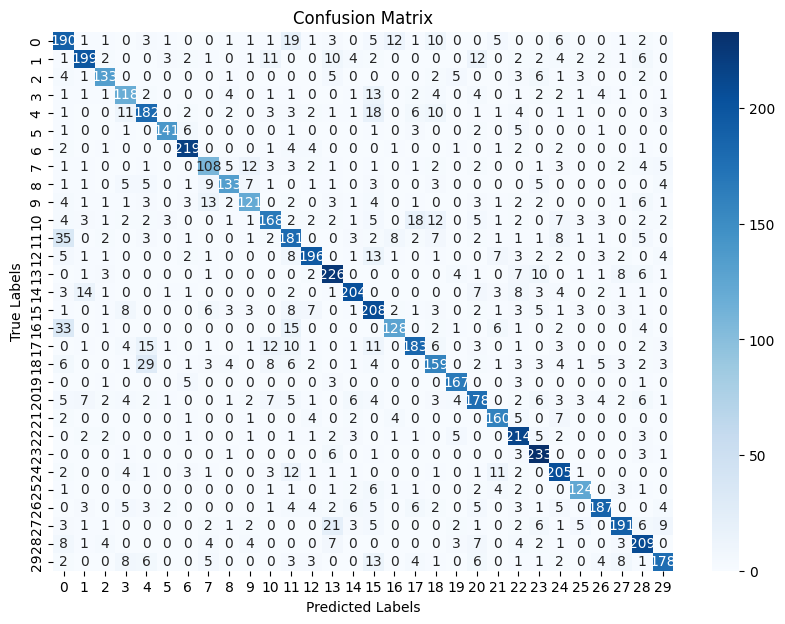

In [36]:
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
from torch.utils.data import DataLoader

# Step 2: Prepare the DataLoader
X_test = torch.tensor(X_test, dtype=torch.float32)  # [num_samples, sequence_length]
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
test_dataset = SpeechDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluation function
def evaluate_model2(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Check the shape of inputs
            print(f"Input shape: {inputs.shape}, Labels shape: {labels.shape}")

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

            # Collect predictions and labels for F1 calculation
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return total_loss / len(loader), accuracy, f1


# Plot confusion matrix
def plot_confusion_matrix(all_labels, all_preds, classes):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Prepare model and run evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpeechCNN(input_size=X_test.shape[1], num_classes=len(np.unique(y_test))).to(device)

# Load the pre-trained model from model.pth
model.load_state_dict(torch.load('model.pth'))
model.eval()

criterion = nn.CrossEntropyLoss()

# Evaluate the model
loss, accuracy, f1 = evaluate_model2(model, test_loader, criterion, device)
print(f'Test Loss: {loss:.4f}, Accuracy: {accuracy * 100:.2f}%, F1 Score: {f1:.4f}')

# Plot the confusion matrix
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

plot_confusion_matrix(all_labels, all_preds, classes=np.unique(y_test))


batch size 16, 32->64->128 -> 512 -> 256 -> 30, learning rate 0.001 -> 0.0015 -> 0.0005, added L2 regularization after 20 epochs and started saving optimazer

Epoch 1/10 - Train Loss: 2.7297 - Train Acc: 0.1845 - Train F1: 0.1655 - Val Loss: 2.2920 - Val Acc: 0.2817 - Val F1: 0.2320

Epoch 2/10 - Train Loss: 2.2167 - Train Acc: 0.3138 - Train F1: 0.3005 - Val Loss: 2.0199 - Val Acc: 0.3635 - Val F1: 0.3443

Epoch 3/10 - Train Loss: 1.9961 - Train Acc: 0.3817 - Train F1: 0.3718 - Val Loss: 2.0214 - Val Acc: 0.3767 - Val F1: 0.3640

Epoch 4/10 - Train Loss: 1.8400 - Train Acc: 0.4346 - Train F1: 0.4264 - Val Loss: 2.1038 - Val Acc: 0.3670 - Val F1: 0.3362

Epoch 5/10 - Train Loss: 1.7145 - Train Acc: 0.4727 - Train F1: 0.4667 - Val Loss: 1.6628 - Val Acc: 0.4834 - Val F1: 0.4704

Epoch 6/10 - Train Loss: 1.6038 - Train Acc: 0.5084 - Train F1: 0.5036 - Val Loss: 1.4923 - Val Acc: 0.5357 - Val F1: 0.5356

Epoch 7/10 - Train Loss: 1.5035 - Train Acc: 0.5410 - Train F1: 0.5372 - Val Loss: 1.3563 - Val Acc: 0.5822 - Val F1: 0.5757

Epoch 8/10 - Train Loss: 1.4065 - Train Acc: 0.5685 - Train F1: 0.5656 - Val Loss: 1.2704 - Val Acc: 0.6161 - Val F1: 0.6146

Epoch 9/10 - Train Loss: 1.3338 - Train Acc: 0.5941 - Train F1: 0.5921 - Val Loss: 1.2351 - Val Acc: 0.6143 - Val F1: 0.6049

Epoch 10/10 - Train Loss: 1.2554 - Train Acc: 0.6173 - Train F1: 0.6154 - Val Loss: 1.1952 - Val Acc: 0.6365 - Val F1: 0.6358

Epoch 1/10 - Train Loss: 1.2805 - Train Acc: 0.6140 - Train F1: 0.6126 - Val Loss: 1.1984 - Val Acc: 0.6342 - Val F1: 0.6360

Epoch 2/10 - Train Loss: 1.2085 - Train Acc: 0.6342 - Train F1: 0.6330 - Val Loss: 1.1255 - Val Acc: 0.6564 - Val F1: 0.6533

Epoch 3/10 - Train Loss: 1.1495 - Train Acc: 0.6532 - Train F1: 0.6521 - Val Loss: 1.0487 - Val Acc: 0.6864 - Val F1: 0.6818

Epoch 4/10 - Train Loss: 1.0925 - Train Acc: 0.6715 - Train F1: 0.6706 - Val Loss: 1.0185 - Val Acc: 0.6936 - Val F1: 0.6942

Epoch 5/10 - Train Loss: 1.0478 - Train Acc: 0.6850 - Train F1: 0.6842 - Val Loss: 0.9966 - Val Acc: 0.7017 - Val F1: 0.7009

Epoch 6/10 - Train Loss: 1.0049 - Train Acc: 0.6967 - Train F1: 0.6961 - Val Loss: 0.9711 - Val Acc: 0.7118 - Val F1: 0.7098

Epoch 7/10 - Train Loss: 0.9673 - Train Acc: 0.7094 - Train F1: 0.7089 - Val Loss: 0.9213 - Val Acc: 0.7223 - Val F1: 0.7218

Epoch 8/10 - Train Loss: 0.9431 - Train Acc: 0.7152 - Train F1: 0.7147 - Val Loss: 0.9182 - Val Acc: 0.7165 - Val F1: 0.7164

Epoch 9/10 - Train Loss: 0.9187 - Train Acc: 0.7215 - Train F1: 0.7211 - Val Loss: 1.0207 - Val Acc: 0.6974 - Val F1: 0.6991

Epoch 10/10 - Train Loss: 0.8958 - Train Acc: 0.7285 - Train F1: 0.7282 - Val Loss: 0.9246 - Val Acc: 0.7290 - Val F1: 0.7296

Epoch 1/5 - Train Loss: 0.7875 - Train Acc: 0.7583 - Train F1: 0.7580 - Val Loss: 0.8115 - Val Acc: 0.7590 - Val F1: 0.7589

Epoch 2/5 - Train Loss: 0.7558 - Train Acc: 0.7691 - Train F1: 0.7689 - Val Loss: 0.8346 - Val Acc: 0.7540 - Val F1: 0.7523

Epoch 3/5 - Train Loss: 0.7404 - Train Acc: 0.7738 - Train F1: 0.7736 - Val Loss: 0.8030 - Val Acc: 0.7580 - Val F1: 0.7578

Epoch 4/5 - Train Loss: 0.7211 - Train Acc: 0.7788 - Train F1: 0.7785 - Val Loss: 0.7829 - Val Acc: 0.7673 - Val F1: 0.7673

Epoch 5/5 - Train Loss: 0.7121 - Train Acc: 0.7815 - Train F1: 0.7813 - Val Loss: 0.7886 - Val Acc: 0.7632 - Val F1: 0.7631

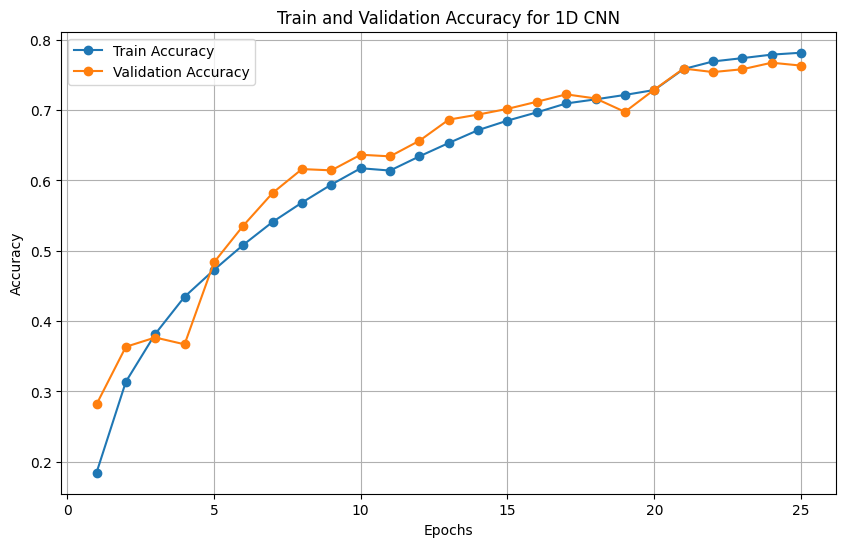

In [37]:
import json
import matplotlib.pyplot as plt

# Load the JSON data from the file
with open('values.json', 'r') as f:
    data = json.load(f)

# Extract epochs, train accuracy, and validation accuracy
epochs = [entry['epoch'] for entry in data]
train_acc = [entry['train_acc'] for entry in data]
val_acc = [entry['val_acc'] for entry in data]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')

# Adding titles and labels
plt.title('Train and Validation Accuracy for 1D CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

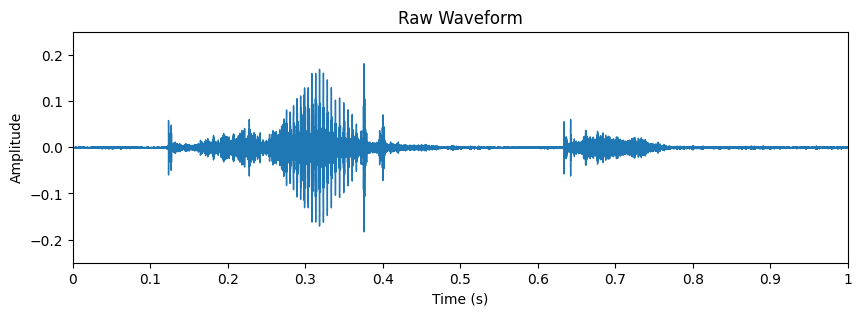

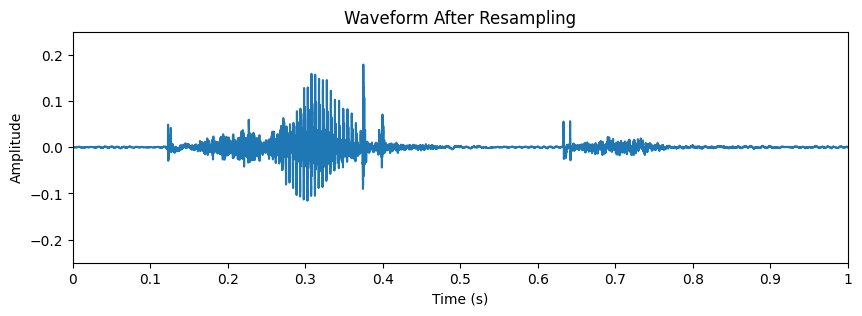

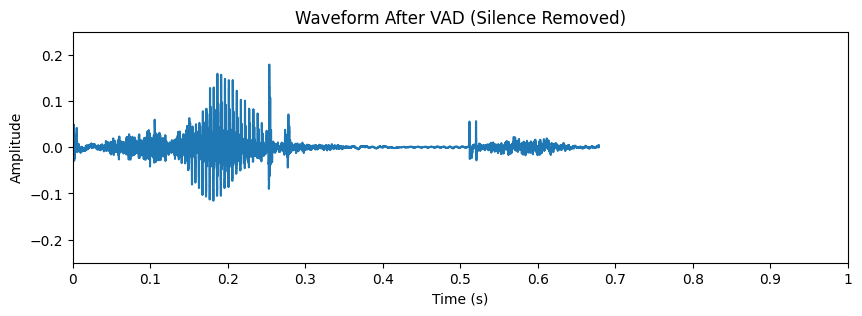

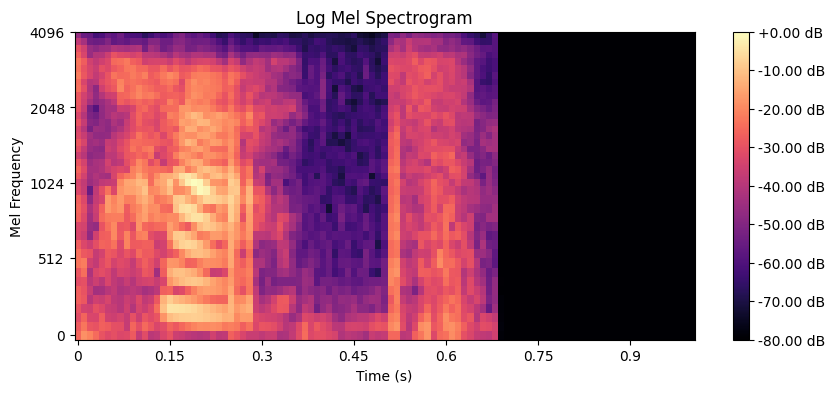

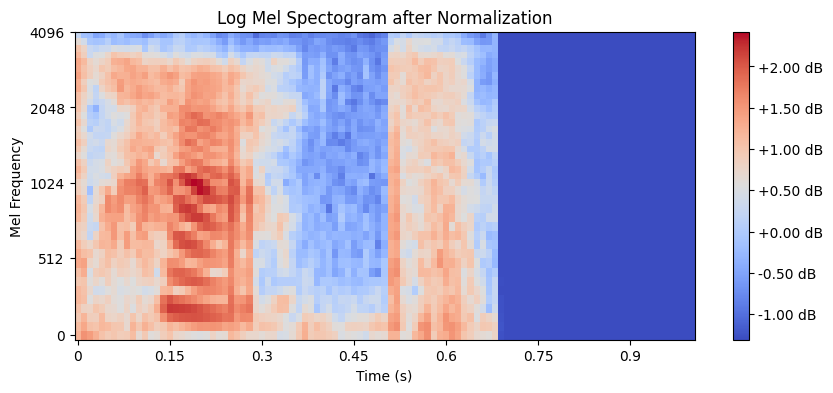

40
101


In [38]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Constants
global_mean = -51.92462921142578
global_std = 21.454496383666992

def plot_waveform(audio, sr, title):
    """Helper function to plot waveform."""
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(audio, sr=sr)
    plt.xlim(0, 1)
    plt.ylim(-.25, .25)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

def plot_spectrogram(log_mel_spec, sr, hop_length, n_fft, title):
    """Helper function to plot spectrogram."""
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_mel_spec, sr=sr, n_fft=n_fft, hop_length=hop_length, x_axis="time", y_axis="mel", fmax=sr/2)
    plt.colorbar(format="%+2.2f dB")
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Mel Frequency")
    plt.show()

def preprocess_audio_spec(filepath, target_freq=8000, n_mels=40, frame_length=0.025, frame_stride=0.01):
    """
    Preprocess an audio file and generate a spectrogram.

    Parameters:
        filepath (str): Path to the .wav file.
        target_freq (int): Target sampling rate (default: 8000 Hz).
        n_mels (int): Number of mel filter banks (default: 40).
        frame_length (float): Window size for STFT in seconds (default: 25ms).
        frame_stride (float): Step size for STFT in seconds (default: 10ms).

    Returns:
        np.ndarray: Log mel spectrogram.
    """
    # 1. Load audio at original sample rate
    audio, original_sr = librosa.load(filepath, sr=None)
    plot_waveform(audio, original_sr, "Raw Waveform")

    # 2. Resample to target frequency
    audio = librosa.resample(audio, orig_sr=original_sr, target_sr=target_freq)
    plot_waveform(audio, target_freq, "Waveform After Resampling")

    # 3. Apply Voice Activity Detection (VAD)
    audio, _ = librosa.effects.trim(audio, top_db=35,  frame_length=1, hop_length=1, aggregate=np.mean)
    plot_waveform(audio, target_freq, "Waveform After VAD (Silence Removed)")

    # 4. Pad or truncate to 1 second (8000 samples)
    max_length = target_freq
    if len(audio) > max_length:
        audio = audio[:max_length]
    else:
        audio = np.pad(audio, (0, max_length - len(audio)))

    # Compute log mel spectrogram
    hop_length = int(frame_stride * target_freq)
    n_fft = int(frame_length * target_freq)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=target_freq, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # NEXT SPECTROGRAM (Plot Log Mel Spectrogram)
    plot_spectrogram(log_mel_spec, target_freq, hop_length, n_fft, "Log Mel Spectrogram")

    # Normalize
    # log_mel_spec = np.nan_to_num(log_mel_spec)
    log_mel_spec = (log_mel_spec - global_mean) / global_std

    # NEXT SPECTROGRAM (Plot Log Mel Spectrogram)
    plot_spectrogram(log_mel_spec, target_freq, hop_length, n_fft, "Log Mel Spectogram after Normalization")

    return log_mel_spec

# Test with a sample file
filepath = "00f0204f_nohash_2.wav"
sth = preprocess_audio_spec(filepath)

print(len(sth))
print(len(sth[0]))